## Предсказывание года выпуска песни по звуковым признакам:

Данные - https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2022-07-05 06:59:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  17.8MB/s    in 13s     

2022-07-05 06:59:44 (15.9 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

### Ridge 

In [5]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

clf = Ridge()  #создаю объект класса Ridge
clf.fit(X_train, y_train) #обучаю Ridge регрессию
print("RMSE для Ridge регрессии %s \n" %mean_squared_error(clf.predict(X_test), y_test, squared=False))

print("RMSE для константного прогноза %s" %mean_squared_error(np.full(y_test.size, y_train.mean()), y_test, squared=False)) #наилучший константный прогноз это среднее

RMSE для Ridge регрессии 9.510160711373397 

RMSE для константного прогноза 10.85246390513634


### Pytorch



In [6]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [7]:
set_random_seed(25) # Устанавливаю сид

In [8]:
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler

In [9]:
#class RMSE(nn.Module): # пишу класс для RMSE лосса
#    def __init__(self):
#        super().__init__()
#        self.mse = nn.MSELoss()
#        
#    def forward(self,prediction,y):
#        return torch.sqrt(self.mse(prediction,y))

In [10]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def plot_history(train_history, val_history, title="loss"): # функция для вывода графиков лосса по батчам и валидационной выборке из 3 семинара
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label="train", zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c="orange", label="val", zorder=2)
    plt.xlabel("train steps")
    
    plt.legend(loc="best")
    plt.grid()

    plt.show()

In [11]:
class Model(nn.Module): # создаю класс для модели
    def __init__(self):
        super(Model, self).__init__()
        self.convs = nn.Sequential(  # определяю последовательность слоев
          nn.Linear(90,200),
          nn.BatchNorm1d(200),
          nn.Dropout(p=0.1),
          nn.LeakyReLU(0.03),
         
          nn.Linear(200, 60),  
          nn.BatchNorm1d(60),
          nn.Dropout(p=0.1),
          nn.LeakyReLU(0.03),

          nn.Linear(60, 100),
          nn.BatchNorm1d(100),
          nn.Dropout(p=0.1),
          nn.LeakyReLU(0.03),

          nn.Linear(100, 1)
        )

    def forward(self, x):
       x = self.convs(x)
       return x

In [12]:
SS = StandardScaler() # создаю объкект класса Standard Scaler для стандартизации данных
mean_train = np.mean(y_train) 
std_train = np.std(y_train)

train_set = torch.utils.data.TensorDataset(torch.tensor(SS.fit_transform(X_train), dtype=torch.float32), # создаю тензор из стандартизированных данных параметров и стандартизированных данных целевой переменной
    torch.tensor((y_train.astype(float)-mean_train)/std_train, dtype=torch.float32))

train_loader = torch.utils.data.DataLoader( # разделяю выборку на батчи размером 200
    train_set, 
    batch_size = 500
)

test_set = torch.utils.data.TensorDataset(torch.tensor(SS.fit_transform(X_test), dtype=torch.float32), # создаю тензор из стандартизированных данных параметров и стандартизированных данных целевой переменной
    torch.tensor((y_test.astype(float)-mean_train)/std_train, dtype=torch.float32))

test_loader = torch.utils.data.DataLoader( # разделяю тестовую выборку на батчи размером 200
    test_set, 
    batch_size=len(y_test)
)

model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0025) # задаю оптимайзер Adam с длинной шага 0.0004
criterion = nn.MSELoss()

In [19]:
def train(model, optimizer, criterion, train_loader, test_loader, n_epohs, mean_tr, std_tr): # функция обучения нейронных сетей
    train_loss_log, test_loss_log = [], []

    for epoch in range(n_epohs): # цикл по эпохам 
      model.train()
      for X_train, y_train in tqdm(train_loader): # прохожусь по всем батчам тренировочной выборки   
          y_pred = model(X_train)[:,0]  # делаю предсказания                    
          loss = criterion(y_pred*std_tr + mean_tr, y_train*std_tr + mean_tr) # считаю лосс 
          loss.backward() # считаю градиенты                                
          optimizer.step() # делаю шаг градиентного спуска                             
          optimizer.zero_grad() # обнуляю градиента
          
          train_loss_log.append(loss.detach().numpy()) # записываю данные лосса в массив

      
      test_epoch_loss = torch.empty(0)
      model.eval() # не записываю градиенты                             
      with torch.no_grad():                          
        for X_test, y_test in tqdm(test_loader):  # прохожусь по всем батчам тренировочной выборки
            y_pred = model(X_test)[:,0]  # делаю предсказания
            test_epoch_loss = criterion(y_pred*std_tr + mean_tr, y_test*std_tr + mean_tr).detach().numpy() # считаю лосс

      clear_output() 
      test_loss_log.append(test_epoch_loss) 
      plt.plot(np.sqrt(test_loss_log), label="val", zorder=1) # вывожу график данных лосса на тесте по эпохам 
      plot_history(np.sqrt(train_loss_log),np.sqrt(test_loss_log), "train val loss") # вывожу график данных лосса на тесте по итерациям
      print(f"Epoch: {epoch}, loss: {np.sqrt(test_epoch_loss)}") # вывожу номер эпохи и лосс


def test(model, criterion, test_loader, mean_tr, std_tr):
    model.eval()
    predicts = torch.empty(0)
    for X_test, y_test in test_loader:  # прохожусь по всем батчам тренировочной выборки
      predicts = torch.cat((predicts, model(X_test)[:,0]), 0) # записываю предсказания модели
    predicts = predicts* std_tr + mean_tr # провожу обратную стандартизацию используя данные по тренировочной выборке
    return predicts

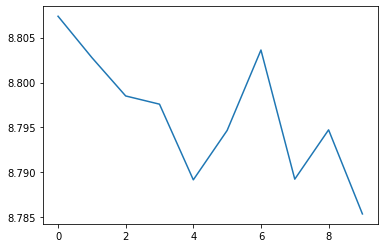

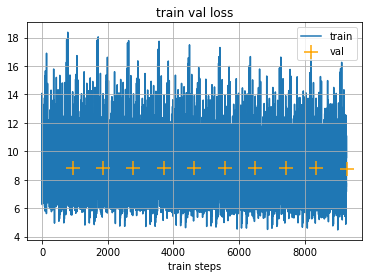

Epoch: 9, loss: 8.785382270812988


In [20]:
train(model, optimizer, criterion, train_loader, test_loader, 10, mean_train, std_train) 

In [21]:
assert test(model, criterion, test_loader, mean_train, std_train).shape[0] == y_test.shape[0] 

In [22]:
predict = test(model, criterion, test_loader, mean_train, std_train)
torch.sqrt(criterion(predict, torch.tensor(y_test, dtype=torch.float32))) # вывожу лосс по тестовой выборке

tensor(8.7854, grad_fn=<SqrtBackward0>)

Сначала я использовал конструкцию где после каждого линейного слоя были использованы слои:

          nn.BatchNorm1d(),
          nn.ReLU(),    
          nn.Dropout(p=0.3)

так я уменьшал ширину слоев с 90 до 64, 32, 16, 8, однако такой подход давал лосс в промежутке от 10.9 до 10.7 и не уменьшался совсем.

Далее я попытался изменить оптимайзер установив ASGD с длинной шага 0.0001, что немного улучшило результат, но все еще не достигал пороговых значений варируясь с 10.4 до 10.6

Далее я менял размер батча и ширину слоев с 90 до 200, 60, 100
Так мне удалось снизить ошибку до 9

и пришел к таким слоям:

          nn.Linear(90,200),
          nn.BatchNorm1d(200),
          nn.Dropout(p=0.1),
          nn.LeakyReLU(0.03),
         
          nn.Linear(200, 60),  
          nn.BatchNorm1d(60),
          nn.Dropout(p=0.1),
          nn.LeakyReLU(0.03),

          nn.Linear(60, 100),
          nn.BatchNorm1d(100),
          nn.Dropout(p=0.1),
          nn.LeakyReLU(0.03),

          nn.Linear(100, 1)

Далее я вернулся к оптимайзеру Adam c длинной шага 0.0025 и батчем = 500

и получил лосс = 8.8

